This notebook is for explaining the main concepts with the most important code provided. For the output of the cells, please look into the other provided file.
We created this notebook to make the code cells more understandable.

# Multiple Approaches:
0. MLP (predicting steps directly - very bad)
1. LSTM for predicting activity + LSTM for predicting step
2. LSTM with wave-signal preprocessing
3. Different LSTM (different pre-processing and post-processing) (increase range, normalize predictions, keeping gyroscope)


### 0. MLP Approach
- Predict the steps directly.
- Test Accuracy: 1,2%


### 1. LSTM for predicting activity + LSTM for predicting step
- Combining the two LSTM, to first predict Activity and use this for predicting the step
- Test Accuracy: 67%

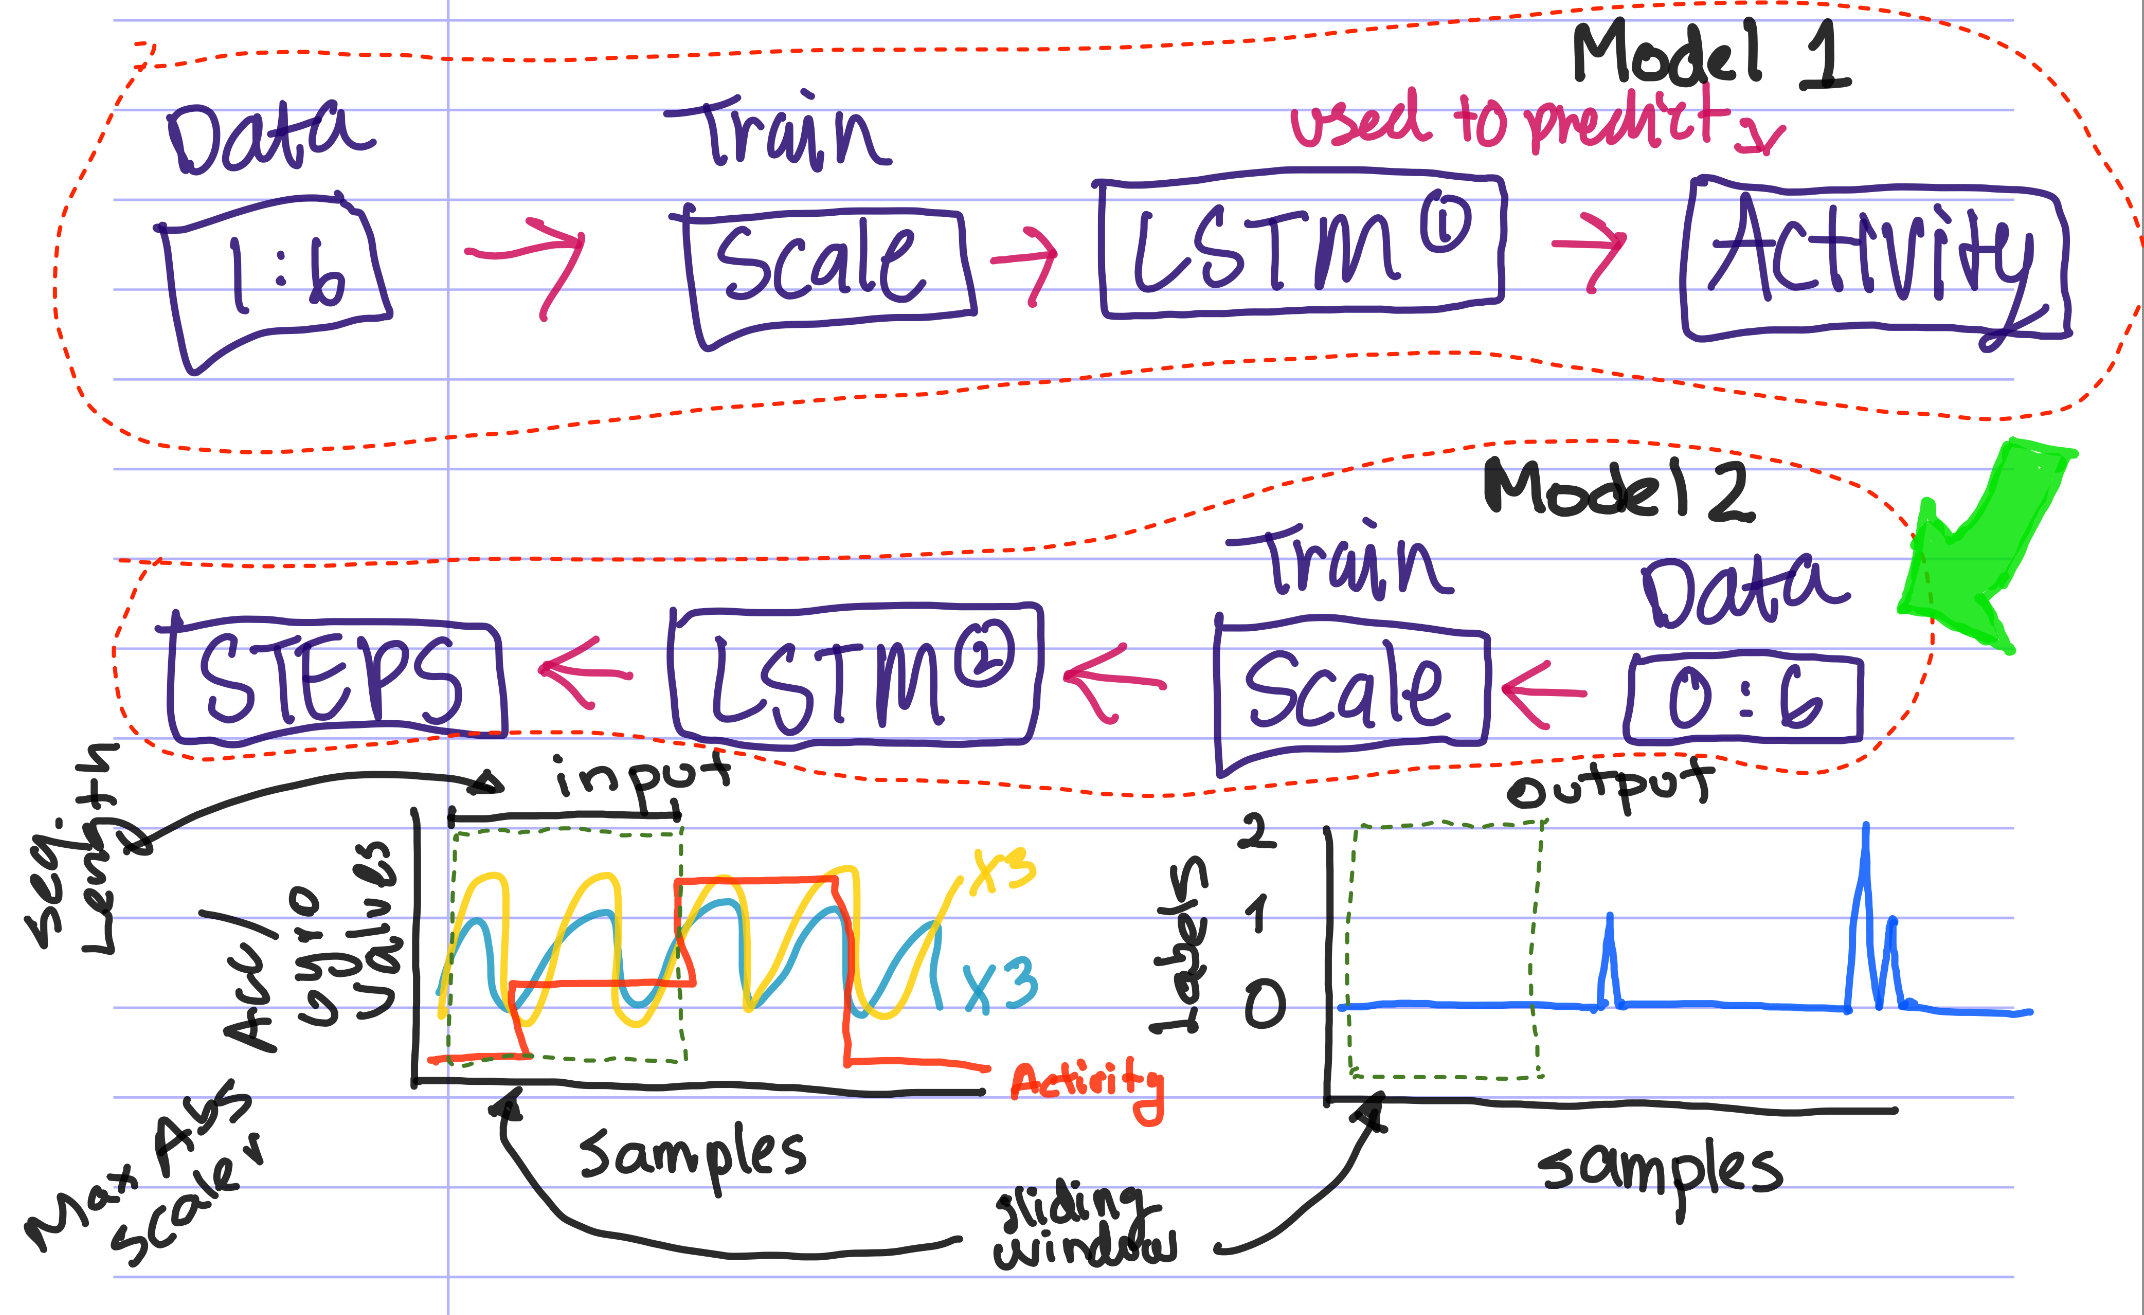

### 2. LSTM with wave-signal preprocessing
- Changing the labels from 10000021000002 to 00000001111111100000000. Transition means it is a step.
- Post-Processing to convert the signal back to predicting a step (when the signal changes from 0 to 1 or from 1 to 0)
- Tried to train LSTM with that as input data.


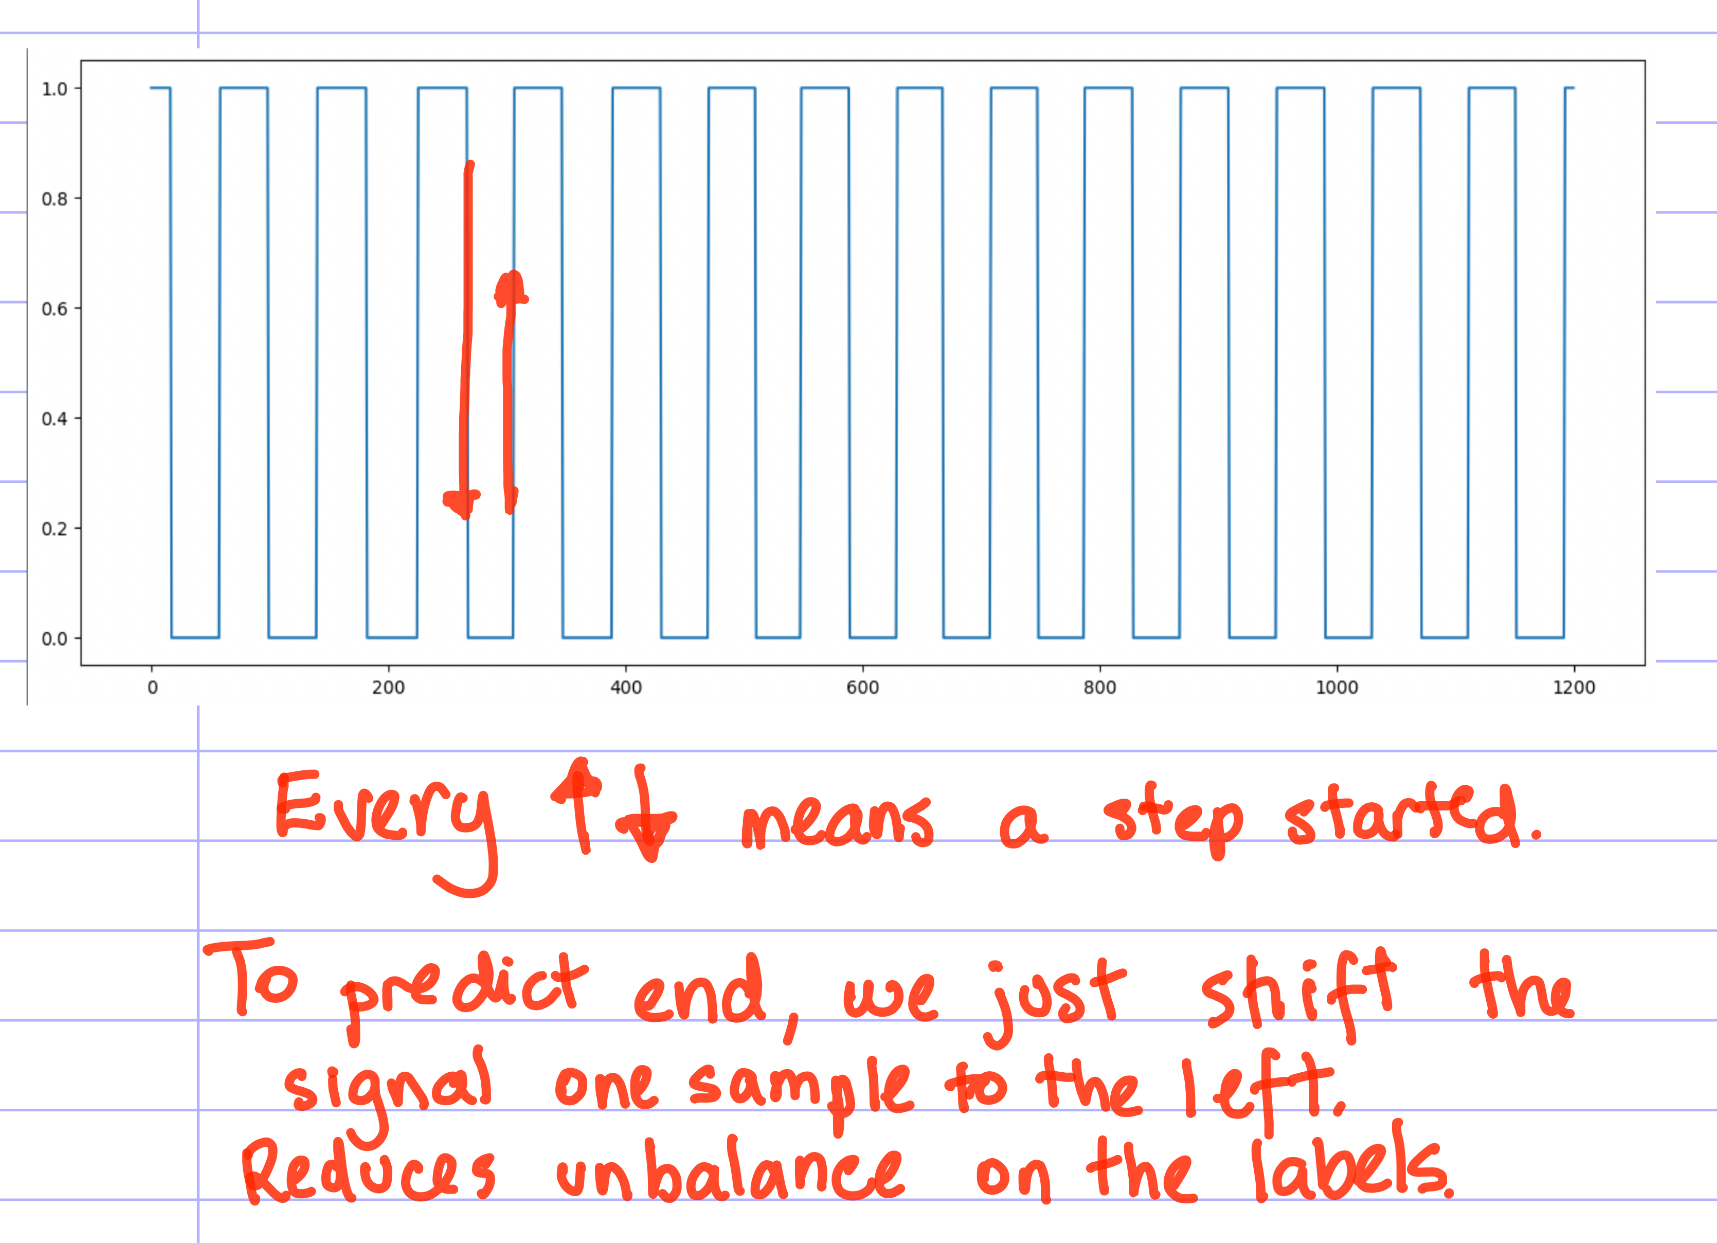

### 3. Different LSTM Architectures
- Preprocessing:
  - Increase range of labels around the step
  - Dropping gyroscope
  - Keeping gyroscope (performed worse than dropping gyroscope)
- Postprocessing:
  - Normalize predicted probabilities to make it look like a sin-wave

- Best Approach: (Accuracy: 76%) based on paper (citation: S. Vandermeeren and H. Steendam, "Deep-Learning-Based Step Detection and Step Length Estimation With a Handheld IMU," in IEEE Sensors Journal, vol. 22, no. 24, pp. 24205-24221, 15 Dec.15, 2022, doi: 10.1109/JSEN.2022.3219412.)


/IMG_9B426A237CC7-1.jpeg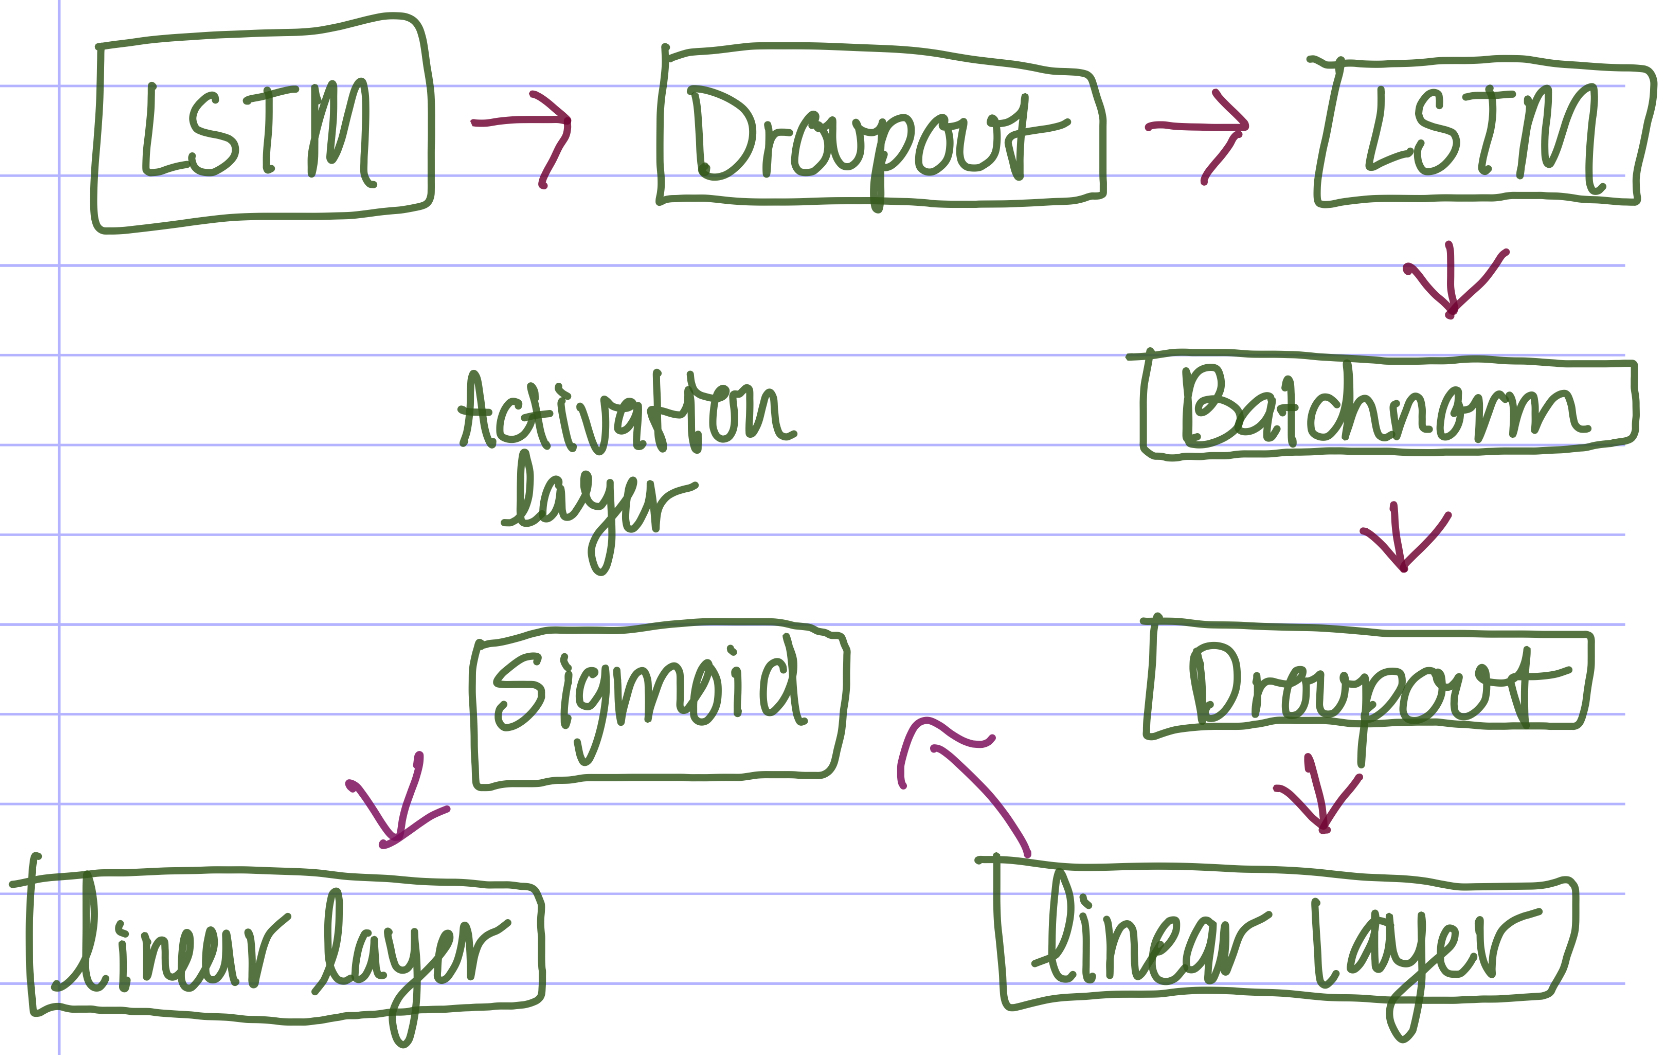

Preprocessing of the input data

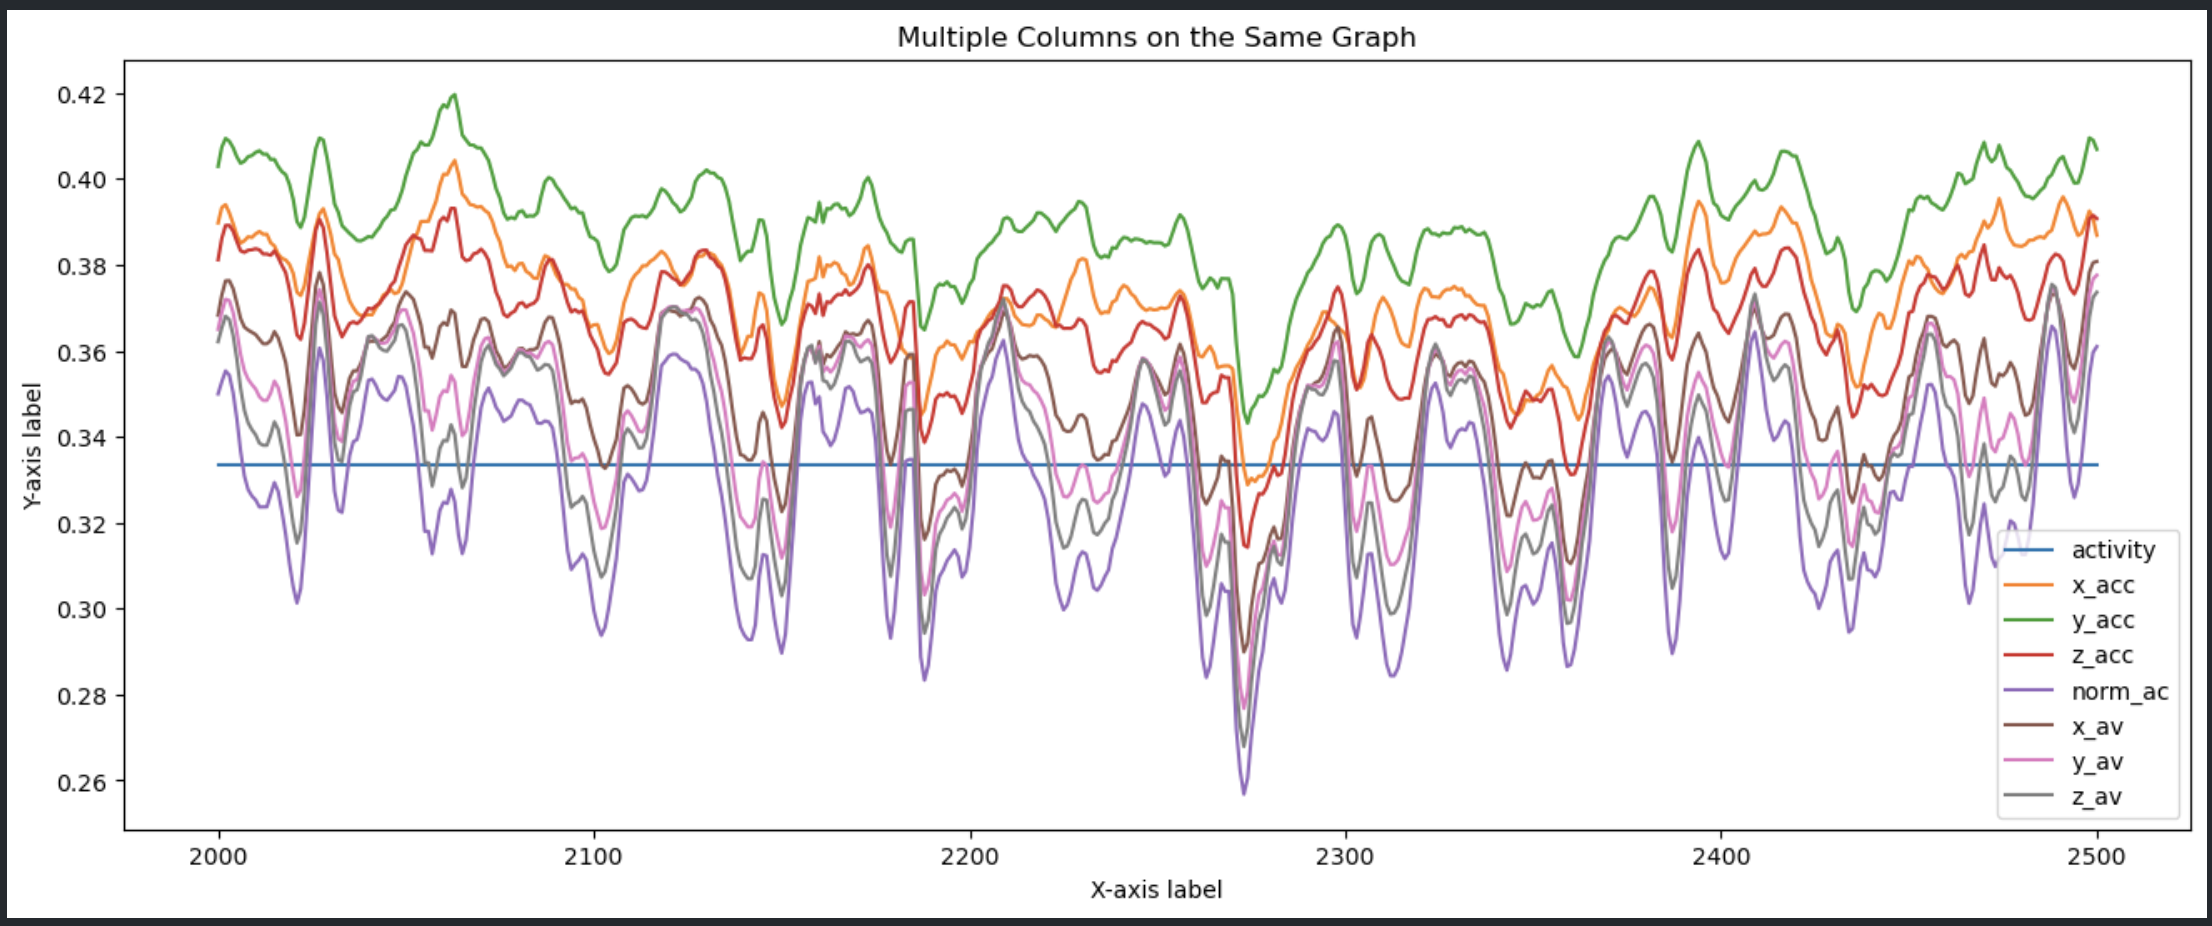

Increasing range of steps - preprocessing of labels

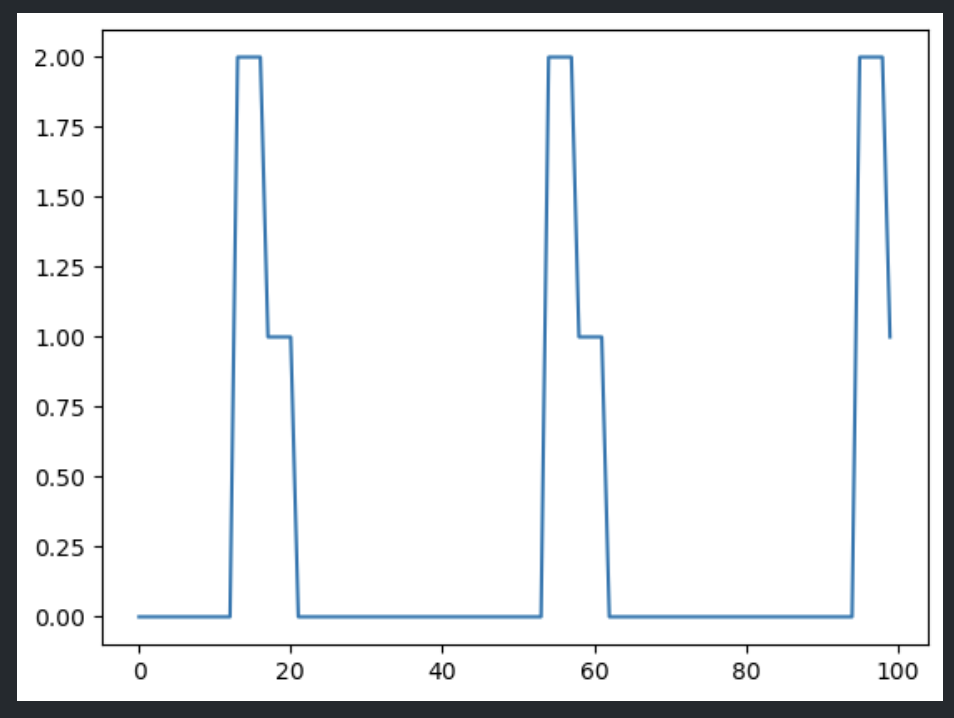

This is what our predictions looks like

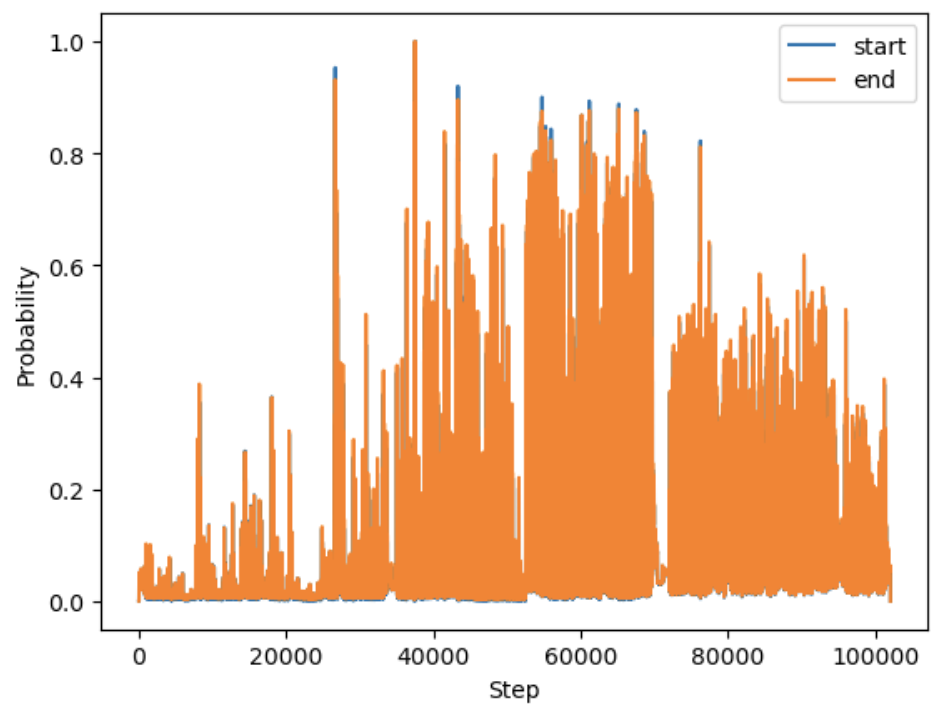

Normalizing the output probabilities - Postprocessing

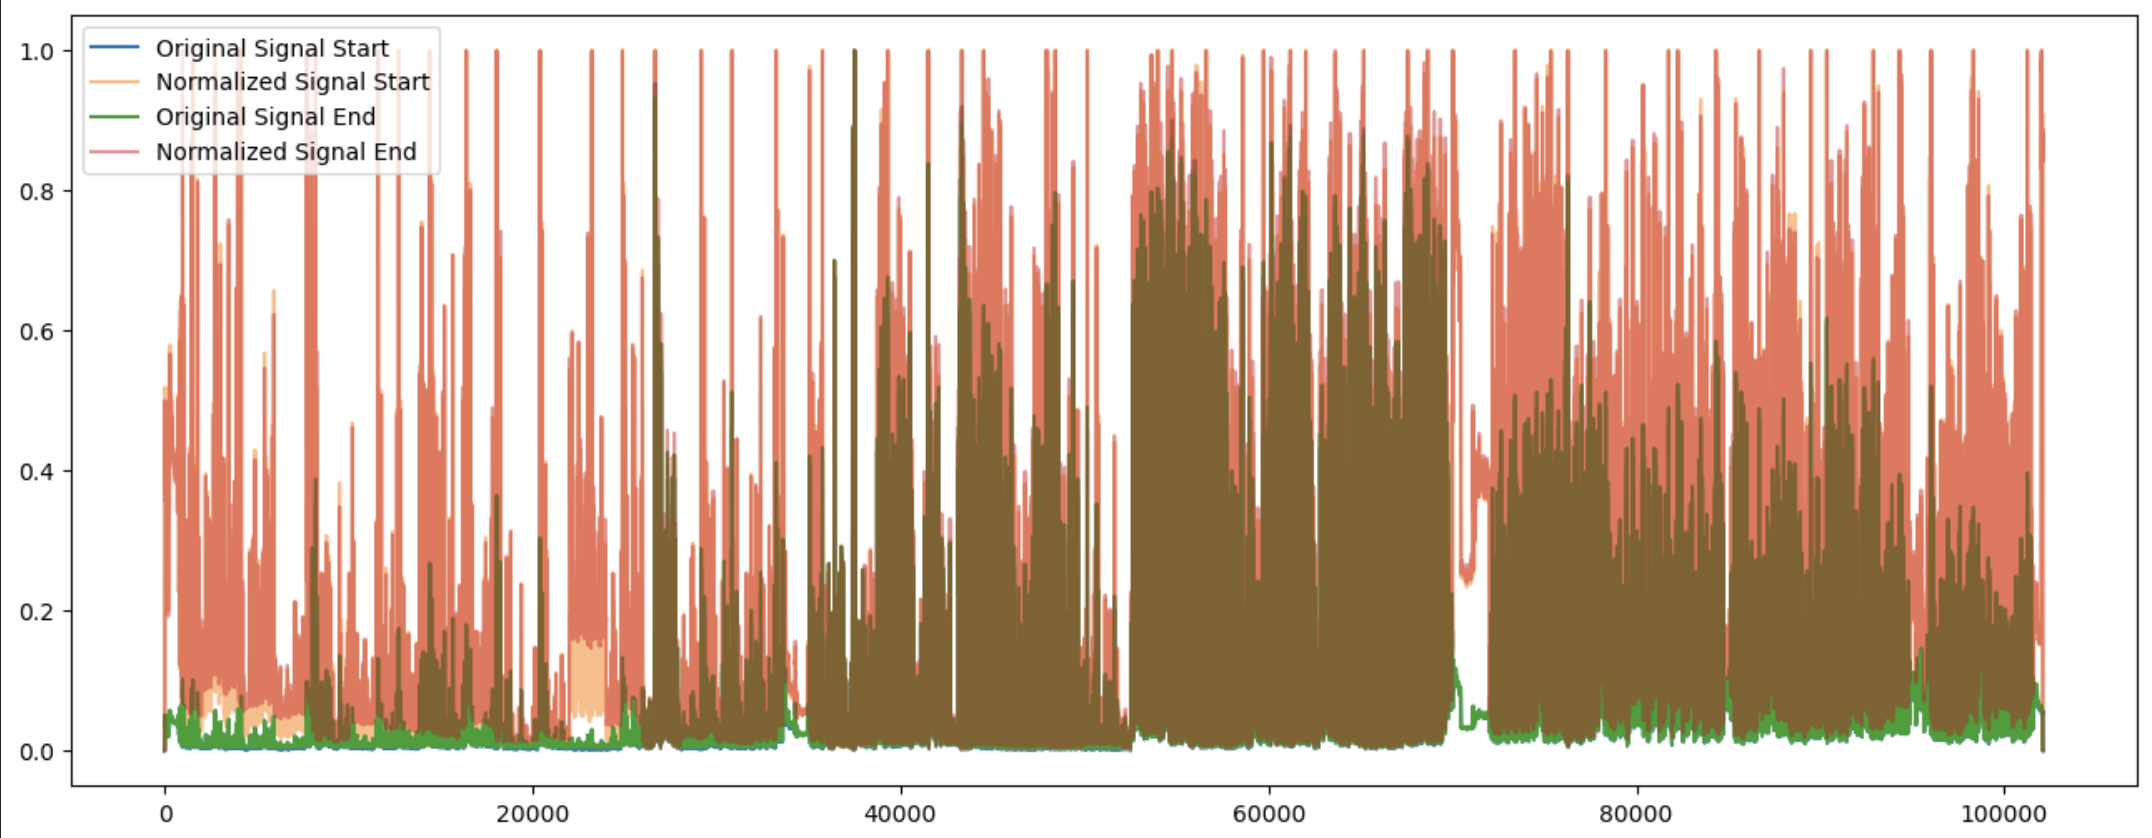

### Imports

In [ ]:
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
import pandas as pd
import os
from torch.utils.data import Dataset, DataLoader
from re import search
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset
from torch.utils.data import random_split
from sklearn import preprocessing
import torch.fft as fft
import scipy.signal as signal
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import precision_recall_curve, average_precision_score

### Helper functions used for all of the approaches

In [ ]:
def get_subdirectories(folder_path):
    # Get the names of the subdirectories
    subdirectories = []
    for item in os.listdir(folder_path):
        item_path = os.path.join(folder_path, item)
        if os.path.isdir(item_path):
            subdirectories.append(item)
    return subdirectories

def get_files_in_subdirectories(folder_path, file_extension='', file_contains=''):
    # Get files within one subdirectory
    files = []
    for root, directories, filenames in os.walk(folder_path):
        for filename in filenames:
            if file_extension == '' and file_contains == '':
                files.append(os.path.join(root, filename))
            elif file_extension != '' and file_contains == '':
                if filename.endswith(file_extension):
                    files.append(os.path.join(root, filename))
            elif file_extension == '' and file_contains != '':
                if file_contains in filename:
                    files.append(os.path.join(root, filename))
            else:
                if file_contains in filename and filename.endswith(file_extension):
                    files.append(os.path.join(root, filename))
    return files

def get_num(text):
    # Get number of the name of a file
    if isinstance(text, list):
        numbers = []
        for item in text:
            number_str = search(r'\d+(?=[^\d]*\.csv)', str(item))[0]
            if number_str:
                numbers.append(number_str)
        return numbers
    else:
        number_str = search(r'\d+(?=[^\d]*\.csv)', str(text))[0]
        return number_str if number_str else None

def read_csv_to_tensor(file_path, tensor_name, tensors_dict):
    dataframe = pd.read_csv(file_path)
    tensor = torch.tensor(dataframe.values)
    # Store the tensor in the dictionary with the specified variable name
    tensors_dict[tensor_name] = tensor

def read_csv_to_tensor2(file_path):
    return pd.read_csv(file_path)

def get_data_into_tensor(path,extensions,labels):
    subdirectories = get_subdirectories(path)

    file_extension = extensions
    label = labels

    tensors = {}

    # Go through all subdirectories
    for i in subdirectories:
        folder_i = path+i
        files_t = get_files_in_subdirectories(folder_i)
        files_n = list(dict.fromkeys(get_num(files_t)))

        # Go through the files of the subdirectories
        for index_j,j in enumerate(files_n):
            name_variable = i+'_'+str(index_j)
            # Handle the file extensions
            for index_k,k in enumerate(file_extension):
                files = get_files_in_subdirectories(folder_i,file_extension=k,file_contains=j)
                name_variableR = i+'_'+j+'_'+label[index_k]

                if index_k == 0:
                    main_df = read_csv_to_tensor2(files[0])
                else:
                    label_df = pd.read_csv(files[0],names = ['start','end'])
                    index_start = sorted(label_df.start.tolist())
                    index_end = sorted(label_df.end.tolist())

            # Add a new column with a specific value for the matching row indexes
            main_df['label1'] = main_df.apply(lambda row: 'start' if row.name in index_start else '', axis=1)
            main_df['label2'] = main_df.apply(lambda row: 'end' if row.name in index_end else '', axis=1)

            # Define the condition for the new column
            condition1 = main_df['label1'] == 'start'
            condition2 = main_df['label2'] == 'end'
            # Assign values based on the condition using np.where()
            main_df['label'] = np.where(condition1,1,
                                    np.where(condition2,1,0))
            main_df = main_df.drop(['label1', 'label2'], axis=1)
            # Convert DataFrame to a tensor
            tensor = torch.tensor(main_df.values)
            # Store the tensor in the dictionary with the specified variable name
            tensors[name_variable] = tensor

    # Labels are:
    # 0 - Neither start nor end
    # 1 - Start
    # 2 - End

    # Loop through the dictionary
    tensor_unified = torch.Tensor()
    for key, value in tensors.items():
        tensor_unified = torch.cat([tensor_unified,value])

    return tensor_unified

# Custom dataset class
class MyDataset(Dataset):
    def __init__(self, data, time_steps):
        self.dataX = data[:][0]
        self.dataY = data[:][1]
        self.time_steps = time_steps

    def __len__(self):
        return len(self.dataX) - self.time_steps + 1

    def __getitem__(self, idx):
        return (self.dataX[idx:idx+self.time_steps],self.dataY[idx:idx+self.time_steps])

# Custom dataset class
class MyDataset2(Dataset):
    def __init__(self, sequence,labels, time_steps):
        self.sequence = sequence
        self.labels = labels
        self.time_steps = time_steps

    def __len__(self):
        return len(self.labels) - self.time_steps + 1

    def __getitem__(self, idx):
        sequence = self.sequence[idx:idx+self.time_steps]
        label = self.labels[idx+int((self.time_steps)/2)]
        return sequence, label

# Custom dataset class
class MyDatasetLSTM(Dataset):
    def __init__(self, data, time_steps):
        self.dataX = data[:][0]
        self.dataY = data[:][1]
        self.time_steps = time_steps

    def __len__(self):
        return len(self.dataX) - self.time_steps + 1

    def __getitem__(self, idx):
        return (self.dataX[idx:idx+self.time_steps],torch.mode(self.dataY[idx:idx+self.time_steps])[0])

# Custom dataset class testing
class MyDatasetLSTM_testing(Dataset):
    def __init__(self, data, time_steps):
        self.data = data
        self.time_steps = time_steps

    def __len__(self):
        return len(self.data) - self.time_steps + 1

    def __getitem__(self, idx):
        return self.data[idx:idx+self.time_steps]


### Data Reading/ Importing

In [ ]:
folder_path = os.getcwd()+'/data/'
file_extension = ['.csv','.csv.stepMixed']
label = ['data','labels']

tensor_unified = get_data_into_tensor(folder_path,file_extension,label)

test_data_path = 'testdata.csv'
dataframe = pd.read_csv(test_data_path)
test_data = torch.tensor(dataframe.values)

data = tensor_unified[:,[1,2,3,4,5,6]]
data = data.float()
labels = tensor_unified[:,0]
labelssteps = tensor_unified[:,7]
labels = labels.long()
labelssteps = labelssteps.long()

training_data = [data,labels]

feature_dim = training_data[0].size(1) # in Features Dimension
class_dim = torch.unique(training_data[1]).size(0) # Out Features Dimension
data_set = TensorDataset(training_data[0],training_data[1])
test_split_per = 0.75
train_size = int(data.size(0)*test_split_per)
test_size = data.size(0) - train_size
train_data, test_data = random_split(data_set, [train_size, test_size])
feature_dim = training_data[0].size(1) # in Features Dimension
class_dim = torch.unique(training_data[1]).size(0) # Out Features Dimension

# 0. Baseline Approach: MLP

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.optim as optim
import matplotlib.pyplot as plt

def mlp_train(train_data,hidden_dims, epochs, batch_size, learning_rate, cuda, plots,feature_dims,class_dims,test_data = None):
    # --- YOUR CODE HERE ---
    b_size = batch_size
    t_data = train_data
    if test_data is not None:
        tt_data = test_data # Test Data Set
    h_dims = hidden_dims # Vector of hidden dimensions
    lr = learning_rate
    cuda = cuda

    # For M1 - Macbook Air
    if (cuda == True):
        device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
    else:
        device = 'cpu'


    # Training Data Loader for training Model
    dl_train = DataLoader(t_data,batch_size=b_size,shuffle=True)
    if test_data is not None:
        dl_test = DataLoader(tt_data,batch_size=100,shuffle=False)


    modules = [] # List used to implement variable Model with n Hidden Dimensions
    feature_dim = feature_dims #train_data[0].size(1) # in Features Dimension
    class_dim = class_dims #torch.unique(train_data[1]).size(0) # Out Features Dimension


    for i in range(len(h_dims)):
        # Batchnorm1d was added though no significant improvement was found, also failed to get images to verify
        # results of model
        if(i == 0):
            # First layer is always in dimensions (28*28) and goes to dimension specified on h_dims
            modules.append(nn.Linear(in_features = feature_dim,out_features = h_dims[i],bias = True))
            # modules.append(nn.BatchNorm1d(h_dims[i]))
            modules.append(nn.LeakyReLU())
        else:
            # Consequent layers go from h_dims[i-1] to h_dims[i]
            modules.append(nn.Linear(in_features = h_dims[i-1],out_features = h_dims[i],bias = True))
            # modules.append(nn.BatchNorm1d(h_dims[i]))
            modules.append(nn.LeakyReLU())

    # Last linear layer of the model, goes from last dimension of h_dim vector to categories to be classified
    modules.append(nn.Linear(in_features = h_dims[len(h_dims)-1],out_features = class_dim,bias = True))
    modules.append(nn.Softmax(dim = 1))

    mlp_model = nn.Sequential(*modules)
    mlp_model = mlp_model.to(device=device)

    # Loss function
    loss_func = nn.CrossEntropyLoss()
    # Optimizer
    optimizer = optim.SGD(mlp_model.parameters(),lr=lr)
    # Lists to obtain results
    epochs_i = []
    losses2 = []
    accuracy_test = []
    accuracy_train = []
    test_loss = []
    d = 0

    # Iteration over epochs
    for epoch in range(epochs):
        d += 1
        loss_batch = 0
        loss_batch_test = 0
        j = 0
        k = 0
        mlp_model.train()
        for batch in dl_train:
            j += 1
            x_batch, y_batch = batch[0].to(device),batch[1].to(device)
            y_batch = y_batch.to(torch.int64)

            preds = mlp_model(x_batch)
            loss = loss_func(preds,y_batch)
            optimizer.zero_grad()
            loss.backward() # get gradients / automatic differentiation
            optimizer.step()
            loss_batch = loss_batch + loss.item()

        loss_batch_avg = loss_batch/j
        epochs_i.append(d)
        losses2.append(loss_batch_avg)
        acctrain = mlp_accuracy(mlp_model,t_data)
        accuracy_train.append(acctrain.item())
        print(f'{d} Iteration - Loss: ',{loss_batch_avg})
        # Calculate the test set loss
        mlp_model.eval()
        if test_data is not None:
            for batchT in dl_test:
                k += 1
                with torch.no_grad():
                    x_batch_t,y_batch_t = batchT[0],batchT[1]
                    y_batch_t = y_batch_t.to(torch.int64)
                    test_preds = mlp_model(x_batch_t)
                    test_loss_value = loss_func(test_preds, y_batch_t)
                    loss_batch_test = loss_batch_test + test_loss_value
            loss_batch_test_avg = loss_batch_test/k
            test_loss.append(loss_batch_test_avg.item())
            acctest = mlp_accuracy(mlp_model,tt_data)
            accuracy_test.append(acctest.item())

        # Condtion to break iteration of model when reaches 0.05 threshold
        if d > 10:
            if loss_batch_avg < 0.05:
                break

    if test_data is not None:
        losses_t = [epochs_i,test_loss]
        accuracy_r_test = [epochs_i,accuracy_test]
        x_accuracy = accuracy_test.index(max(accuracy_r_test[1]))+1
        y_accuracy = max(accuracy_r_test[1])

    losses_r = [epochs_i,losses2]
    accuracy_r_train = [epochs_i,accuracy_train]
    # Plots
    if plots == True:
        fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10, 5))
        ax1.plot(losses_r[0],losses_r[1],'o',ls = '-',label = 'Avg Training Loss')
        if test_data is not None:
            ax1.plot(losses_t[0],losses_t[1],'o',ls = '-',label = 'Avg Test Loss')
        ax1.legend(loc='best')
        ax1.set_xlabel('Epochs')
        ax1.set_ylabel('Average Loss')
        ax1.set_title('Average Loss vs Epochs')
        ax2.plot(accuracy_r_train[0],accuracy_r_train[1],'o',ls = '-',label = 'Training Accuracy')
        if test_data is not None:
            ax2.plot(accuracy_r_test[0],accuracy_r_test[1],'o',ls = '-',label = 'Test Accuracy')
        ax2.legend(loc='best')
        ax2.set_xlabel('Epochs')
        ax2.set_ylabel('Accuracy')
        ax2.set_title('Accuracy vs Epochs')
        if test_data is not None:
            return mlp_model,(losses2,test_loss),fig
        else:
            return mlp_model,losses2,fig

    else:
        return mlp_model,losses

def mlp_accuracy(mlp_model,test_data):

    # Data loader to calculate accuracy of model
    dl_test = DataLoader(test_data,batch_size=100,shuffle=False)
    correct = 0
    total = 0

    for batch in dl_test:
        test_logit = mlp_model(batch[0])
        pred = test_logit.max(dim=1).indices
        labels = batch[1]
        total += labels.size(0)
        correct += (pred == labels).sum()
    accuracy = 100*correct/total
    return accuracy



train_data = tensor_unified[:, torch.arange(tensor_unified.size(1)) != 0]
train_data = train_data.to(torch.float32)
hidden_dims = [10]
epochs = 5
batch_size = 10
learning_rate = 0.08
cuda = False
plots = True
test_data = test_data.to(torch.float32)

mlp_model, losses = mlp_train(train_data,hidden_dims, epochs, batch_size, learning_rate, cuda, plots,test_data)

### 1. Approach: LSTM for predicting activity + LSTM for predicting step

In [ ]:
# Example usage
batch_size = 64

dataloader = DataLoader(train_data_scaled, batch_size=batch_size, shuffle=True,drop_last= True)
dataloaderValidate = DataLoader(test_data_scaled, batch_size=batch_size, shuffle=False,drop_last= True)

# LSTM for predicting the activity
class LSTMClassifier(nn.Module):

    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim,dropout_lstm = 0.0):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.rnn = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True,bias = True,dropout = dropout_lstm)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.sfm = nn.Softmax(dim = 1)
        self.batch_size = None
        self.hidden = None

    def forward(self, x):
        h0, c0 = self.init_hidden(x)
        out, (hn, cn) = self.rnn(x, (h0, c0))
        out = out[:, -1, :]
        out = self.fc(out)
        return out

    def init_hidden(self, x):
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim)
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim)
        return [t for t in (h0, c0)]

print('Preparing datasets')

input_dim = 6
hidden_dim = 100
layer_dim = 1
output_dim = 4

lr = 0.01
n_epochs = 15
# iterations_per_epoch = len(train_dl)
best_acc = 0
patience, trials = 5, 0

model = LSTMClassifier(input_dim, hidden_dim, layer_dim, output_dim)
criterion = nn.CrossEntropyLoss()
opt = torch.optim.RMSprop(model.parameters(), lr=lr)

print('Start model training')

# Training the model
for epoch in range(1, n_epochs + 1):
    j = 0
    for i, (x_batch, y_batch) in enumerate(dataloader):
        j+=1
        model.train()
        opt.zero_grad()
        out = model(x_batch)
        loss = criterion(out, y_batch)
        loss.backward()
        opt.step()

    model.eval()
    correct, total = 0, 0
    for j, (x_batch_v, y_batch_v) in enumerate(dataloaderValidate):
        out = model(x_batch_v)
        preds = F.log_softmax(out, dim=1).argmax(dim=1)
        total += y_batch_v.size(0)
        correct += (preds == y_batch_v).sum().item()

    acc = correct / total
    print(f'Accuracy epoch {epoch} {acc:2.2%}')
    if epoch % 5 == 0:
        print(f'Epoch: {epoch:3d}. Loss: {loss.item():.4f}. Acc.: {acc:2.2%}')

    if acc > best_acc:
        trials = 0
        best_acc = acc
        torch.save(model.state_dict(), 'best.pth')
        print(f'Epoch {epoch} best model saved with accuracy: {best_acc:2.2%}')
    else:
        trials += 1
        if trials >= patience:
            print(f'Early stopping on epoch {epoch}')
            break


In [ ]:
folder_path = os.getcwd()+'/data/'
file_extension = ['.csv','.csv.stepMixed']
label = ['data','labels']

tensor_unified = get_data_into_tensor(folder_path,file_extension,label)

test_data_path = 'testdata.csv'
dataframe = pd.read_csv(test_data_path)
test_data = torch.tensor(dataframe.values)

data = tensor_unified[:,[0,1,2,3,4,5,6]]
data = data.float()
labels = tensor_unified[:,7]
labels = labels.long()

# Preparing training data
training_data = [data,labels]

feature_dim = training_data[0].size(1) # in Features Dimension
class_dim = torch.unique(training_data[1]).size(0) # Out Features Dimension
data_set = TensorDataset(training_data[0],training_data[1])
test_split_per = 0.75
train_size = int(data.size(0)*test_split_per)
test_size = data.size(0) - train_size
train_data, test_data = random_split(data_set, [train_size, test_size])
feature_dim = training_data[0].size(1) # in Features Dimension
class_dim = torch.unique(training_data[1]).size(0) # Out Features Dimension


# Scaling the training data
scalerSteps = preprocessing.MaxAbsScaler()
data_scaled = torch.tensor(scalerSteps.fit_transform(data))
data_scaled = data_scaled.float()

training_data_scaled = [data_scaled,labels]

feature_dim = training_data_scaled[0].size(1) # in Features Dimension
class_dim = torch.unique(training_data_scaled[1]).size(0) # Out Features Dimension
test_split_per = 0.75
train_size = int(data_scaled.size(0)*test_split_per)
test_size = data_scaled.size(0) - train_size
datasetlstm = MyDataset(training_data_scaled,time_steps=40)
train_data_scaled_step, test_data_scaled_step = random_split(datasetlstm, [0.75, 0.25])
feature_dim = training_data[0].size(1) # in Features Dimension
class_dim = torch.unique(training_data[1]).size(0) # Out Features Dimension


# Classifier for predicting the steps with the activity as input
class LSTMClassifier_steps(nn.Module):

    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim,dropout_lstm = 0.0):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.rnn = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True,bias = True,dropout = dropout_lstm)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.batch_size = None
        self.hidden = None

    def forward(self, x):
        h0, c0 = self.init_hidden(x)
        out, (hn, cn) = self.rnn(x, (h0, c0))
        # out = out[:, :, :]
        out = self.fc(out)
        out = torch.permute(out,[0,2,1])
        return out

    def init_hidden(self, x):
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim)
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim)
        return [t for t in (h0, c0)]


dataloader = DataLoader(train_data_scaled_step, batch_size=batch_size, shuffle=True,drop_last= True)
dataloaderValidate = DataLoader(test_data_scaled_step, batch_size=batch_size, shuffle=False,drop_last= True)

print('Preparing datasets')

input_dim = 7
hidden_dim = 120
layer_dim = 1
output_dim = 3

lr = 0.01
n_epochs = 15
best_acc = 0
patience, trials = 8, 0

model = LSTMClassifier_steps(input_dim, hidden_dim, layer_dim, output_dim)
criterion = nn.CrossEntropyLoss()
opt = torch.optim.RMSprop(model.parameters(), lr=lr)

print('Start model training')

for epoch in range(1, n_epochs + 1):
    j = 0
    for i, (x_batch, y_batch) in enumerate(dataloader):
        j+=1
        model.train()
        opt.zero_grad()
        out = model(x_batch)
        loss = criterion(out, y_batch)
        loss.backward()
        opt.step()

    model.eval()
    correct, total = 0, 0
    for j, (x_batch_v, y_batch_v) in enumerate(dataloaderValidate):
        out = model(x_batch_v)
        preds = F.log_softmax(out, dim=1).argmax(dim=1)
        total += (y_batch_v.size(0)*y_batch_v.size(1))
        correct += (preds == y_batch_v).sum().item()

    acc = correct / total
    print(f'Accuracy epoch {epoch} {acc:2.2%}')
    if epoch % 5 == 0:
        print(f'Epoch: {epoch:3d}. Loss: {loss.item():.4f}. Acc.: {acc:2.2%}')

    if acc > best_acc:
        trials = 0
        best_acc = acc
        torch.save(model.state_dict(), 'best_steps_lstm.pth')
        print(f'Epoch {epoch} best model saved with accuracy: {best_acc:2.2%}')
    else:
        trials += 1
        if trials >= patience:
            print(f'Early stopping on epoch {epoch}')
            break

Activity prediction

In [ ]:
# Classifier that loads the model to predict
class LSTMClassifier(nn.Module):

    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim,dropout_lstm = 0.0):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.rnn = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True,bias = True,dropout = dropout_lstm)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.sfm = nn.Softmax(dim = 1)
        self.batch_size = None
        self.hidden = None

    def forward(self, x):
        h0, c0 = self.init_hidden(x)
        out, (hn, cn) = self.rnn(x, (h0, c0))
        out = out[:, -1, :]
        out = self.fc(out)
        return out

    def init_hidden(self, x):
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim)
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim)
        return [t for t in (h0, c0)]

path_activity_model = 'best_activity_lstm.pth'

input_dim = 6
hidden_dim = 100
layer_dim = 1
output_dim = 4

model = LSTMClassifier(input_dim, hidden_dim, layer_dim, output_dim)
model.load_state_dict(torch.load(path_activity_model))

test_data = torch.tensor(dataframe.values)
test_data_scaled_act = torch.tensor(scaler.transform(test_data))
test_data_scaled_act = test_data_scaled_act.float()


dataset = MyDatasetLSTM_testing(test_data_scaled_act,time_steps=40)

# # Set the batch size
batch_size = 32

# # Create a data loader for the dataset
data_loader = DataLoader(dataset, batch_size=batch_size)

# # Set the model in evaluation mode
model.eval()

# # Initialize lists to store the predicted labels and ground truth labels
predicted_labels = []

# Disable gradient calculation
k=0
with torch.no_grad():
    # Iterate over batches in the data loader
    for inputs in data_loader:

        # Forward pass through the model
        outputs = model(inputs)
        pred_probab = nn.Softmax(dim=1)(outputs)
        y_pred = pred_probab.argmax(1)
        if(y_pred.shape[0]!= 32):
            print(f'shape {y_pred.shape} k: {k}')
        k+=1
        # Append the predicted and ground truth labels to the respective lists
        predicted_labels.extend(y_pred)


Step prediction by taking every n-th prediction of the LSTM (67%)

In [ ]:
test_data = torch.tensor(dataframe.values)
zeros_pad = torch.zeros(39)
activity_label = torch.cat((torch.tensor(predicted_labels),zeros_pad),dim=0)
activity_label = activity_label.view(activity_label.shape[0],1)
print(f'act size {activity_label.shape} test size {test_data.shape}')
test_data_w_act = torch.cat((activity_label,test_data),dim=1)
print(f'act size {test_data_w_act.shape}')

test_data_scaled_steps = torch.tensor(scalerSteps.transform(test_data_w_act))
test_data_scaled_steps = test_data_scaled_steps.float()


predicted_labels_one = predicted_labels[:,1]
zeros_pad = torch.zeros((11))
predicted_labels_start = torch.cat((predicted_labels_one,zeros_pad),dim=0)
predicted_labels_end = torch.roll(torch.cat((predicted_labels_one,zeros_pad),dim=0),shifts=1,dims=0)
result_labels = torch.vstack((predicted_labels_start, predicted_labels_end))
result_labels = result_labels.t()
print(f"Predicted class: {result_labels} {result_labels.shape}")


# test_preds = test_preds[:, torch.arange(test_preds.size(1)) != 0]
array_data = result_labels.numpy()

# Define header names
header_names = ['start', 'end']  # Replace with your actual header names
df = pd.DataFrame(array_data, columns=header_names)  # Replace with your actual column names
df.index.name = 'index'  # Specify the name of the index column

# Save the DataFrame to a CSV file
df.to_csv('data_2lstms_40_step_length_mdw_w_activity.csv')

Step prediction by averaging the LSTM outputs (70%)

In [ ]:
path_steps_model = 'best_steps_lstm.pth'

input_dim = 7
hidden_dim = 120
layer_dim = 1
output_dim = 3
ts = 40
cal_tensor_start = torch.full((2*ts, 2*ts), float('nan'))
cal_tensor_end = torch.full((2*ts, 2*ts), float('nan'))
nan_reset_row_tensor = torch.full((1, 2*ts), float('nan'))
starts_results = []
ends_results = []

model = LSTMClassifier_steps(input_dim, hidden_dim, layer_dim, output_dim)
model.load_state_dict(torch.load(path_steps_model))


dataset = MyDatasetLSTM_testing(test_data_scaled_steps,time_steps=40)

# # Set the batch size
batch_size = 40

# # Create a data loader for the dataset
data_loader = DataLoader(dataset, batch_size=batch_size,drop_last= False)

# # Set the model in evaluation mode
model.eval()

# # Initialize lists to store the predicted labels and ground truth labels
predicted_labels = torch.empty((0, 2),dtype=torch.float32)
y=0
# Disable gradient calculation
with torch.no_grad():
    # Iterate over batches in the data loader
    for inputs in data_loader:
        # Forward pass through the model
        bs_it = inputs.shape[0]
        outputs = model(inputs)
        pred_probab = nn.Softmax(dim=1)(outputs)
        start_t = pred_probab[:,1,:]
        end_t = pred_probab[:,2,:]
        for i in range(bs_it):
            start_t_b = start_t[i,:]
            end_t_b = end_t[i,:]
            cal_tensor_start = torch.roll(cal_tensor_start,shifts=-1,dims=0)
            cal_tensor_start = torch.roll(cal_tensor_start,shifts=-1,dims=1)
            cal_tensor_end = torch.roll(cal_tensor_end,shifts=-1,dims=0)
            cal_tensor_end = torch.roll(cal_tensor_end,shifts=-1,dims=1)
            cal_tensor_start[(ts-1),(ts):(2*ts)] = start_t_b
            cal_tensor_end[(ts-1),(ts):(2*ts)] = end_t_b
            averages_start = torch.nanmean(cal_tensor_start, dim=0)
            averages_end = torch.nanmean(cal_tensor_end, dim=0)
            val_start=averages_start[0]
            val_end=averages_end[0]
            cal_tensor_start[:,0] = nan_reset_row_tensor
            cal_tensor_end[:,0] = nan_reset_row_tensor
            if torch.isnan(val_start) == False:
                starts_results.append(val_start.item())
                ends_results.append(val_end.item())
    for j in range(2*ts):
        cal_tensor_start = torch.roll(cal_tensor_start,shifts=-1,dims=0)
        cal_tensor_start = torch.roll(cal_tensor_start,shifts=-1,dims=1)
        cal_tensor_end = torch.roll(cal_tensor_end,shifts=-1,dims=0)
        cal_tensor_end = torch.roll(cal_tensor_end,shifts=-1,dims=1)
        cal_tensor_start[(ts-1),(ts):(2*ts)] = start_t_b
        cal_tensor_end[(ts-1),(ts):(2*ts)] = end_t_b
        averages_start = torch.nanmean(cal_tensor_start, dim=0)
        averages_end = torch.nanmean(cal_tensor_end, dim=0)
        val_start=averages_start[0]
        val_end=averages_end[0]
        cal_tensor_start[:,0] = nan_reset_row_tensor
        cal_tensor_end[:,0] = nan_reset_row_tensor
        if torch.isnan(val_start) == False:
            starts_results.append(val_start.item())
            ends_results.append(val_end.item())

### 2. Approach: LSTM with wave-signal preprocessing

In [ ]:
def get_data_into_tensor(path,extensions,labels):
    subdirectories = get_subdirectories(path)

    file_extension = extensions
    label = labels

    tensors = {}

    for i in subdirectories:
        folder_i = path+i
        files_t = get_files_in_subdirectories(folder_i)
        files_n = list(dict.fromkeys(get_num(files_t)))
        for index_j,j in enumerate(files_n):
            name_variable = i+'_'+str(index_j)
            for index_k,k in enumerate(file_extension):
                files = get_files_in_subdirectories(folder_i,file_extension=k,file_contains=j)
                name_variableR = i+'_'+j+'_'+label[index_k]
                if index_k == 0:
                    main_df = read_csv_to_tensor2(files[0])
                else:
                    label_df = pd.read_csv(files[0],names = ['start','end'])
                    index_start = sorted(label_df.start.tolist())
                    index_end = sorted(label_df.end.tolist())
            # Add a new column with a specific value for the matching row indexes
            main_df['label1'] = main_df.apply(lambda row: 'start' if row.name in index_start else '', axis=1)
            main_df['label2'] = main_df.apply(lambda row: 'end' if row.name in index_end else '', axis=1)

            # Define the condition for the new column
            condition1 = main_df['label1'] == 'start'
            condition2 = main_df['label2'] == 'end'
            # Assign values based on the condition using np.where()
            main_df['label'] = np.where(condition1,1,
                                    np.where(condition2,2,0))
            main_df = main_df.drop(['label1', 'label2'], axis=1)


            steps1=[]
            steps2=[]
            step = False
            for index, row in main_df.iterrows():
                if row['label'] == 1:
                    step = not step  # Toggle the value of 'step'
                if step:
                    steps1.append(index)
                else:
                    steps2.append(index)

            main_df['label'] = main_df.apply(lambda row: 1 if row.name in steps1 else 0, axis=1)
            # Convert DataFrame to a tensor
            tensor = torch.tensor(main_df.values)
            # Store the tensor in the dictionary with the specified variable name
            tensors[name_variable] = tensor

    # Labels are:
    # 0 - Neither start nor end
    # 1 - Start
    # 2 - End

    # Loop through the dictionary
    tensor_unified = torch.Tensor()
    for key, value in tensors.items():
        tensor_unified = torch.cat([tensor_unified,value])

    return tensor_unified

### 3. Different LSTM architectures
- We tried different parameters and approaches here, this is the basic code for it
- Code is after the paper: S. Vandermeeren and H. Steendam, "Deep-Learning-Based Step Detection and Step Length Estimation With a Handheld IMU," in IEEE Sensors Journal, vol. 22, no. 24, pp. 24205-24221, 15 Dec.15, 2022, doi: 10.1109/JSEN.2022.3219412.

In [ ]:
class LSTMClassifier_steps_dropout(nn.Module):

    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim,dropout_lstm = 0.2,int_dim = 128):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.rnn = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True,bias = True,dropout = dropout_lstm)
        self.bn = nn.BatchNorm1d(hidden_dim)  # Batch normalization layer
        self.dropout = nn.Dropout(dropout_lstm)
        self.fc = nn.Linear(hidden_dim,int_dim)
        self.sigmoid = nn.Sigmoid()
        self.fc2 = nn.Linear(int_dim,output_dim)

    def forward(self, x):
        h0, c0 = self.init_hidden(x)
        out, (hn, cn) = self.rnn(x, (h0, c0))
        out = self.bn(out.transpose(1, 2)).transpose(1, 2)  # Batch normalization
        out = self.dropout(out)  # Dropout
        out = out[:, -1, :]
        out = self.fc(out)
        out = self.sigmoid(out)
        out = self.fc2(out)
        return out

    def init_hidden(self, x):
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim)
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim)
        return [t for t in (h0, c0)]